<a href="https://colab.research.google.com/github/mahdiheidari721/AI-Internship/blob/master/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [ ]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH 1/30
	 partial train loss (single batch): 0.252970
	 partial train loss (single batch): 0.245909
	 partial train loss (single batch): 0.240533
	 partial train loss (single batch): 0.235665
	 partial train loss (single batch): 0.231927
	 partial train loss (single batch): 0.228340
	 partial train loss (single batch): 0.225078
	 partial train loss (single batch): 0.222135
	 partial train loss (single batch): 0.220129
	 partial train loss (single batch): 0.217648
	 partial train loss (single batch): 0.215239
	 partial train loss (single batch): 0.212985
	 partial train loss (single batch): 0.211446
	 partial train loss (single batch): 0.208993
	 partial train loss (single batch): 0.206686
	 partial train loss (single batch): 0.205302
	 partial train loss (single batch): 0.203216
	 partial train loss (single batch): 0.201082
	 partial train loss (single batch): 0.198950
	 partial train loss (single batch): 0.197156
	 partial train loss (single batch): 0.195773
	 partial train loss (s

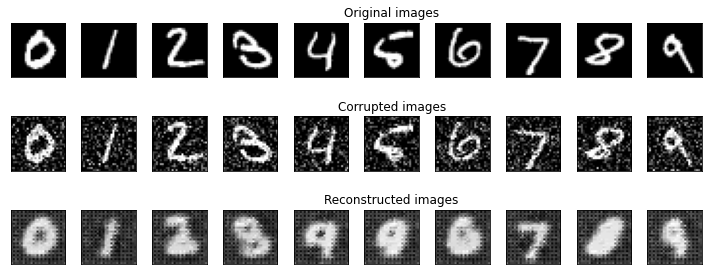

EPOCH 2/30
	 partial train loss (single batch): 0.065355
	 partial train loss (single batch): 0.065990
	 partial train loss (single batch): 0.065754
	 partial train loss (single batch): 0.064748
	 partial train loss (single batch): 0.063610
	 partial train loss (single batch): 0.063502
	 partial train loss (single batch): 0.064793
	 partial train loss (single batch): 0.064143
	 partial train loss (single batch): 0.063852
	 partial train loss (single batch): 0.063516
	 partial train loss (single batch): 0.064003
	 partial train loss (single batch): 0.064095
	 partial train loss (single batch): 0.060858
	 partial train loss (single batch): 0.062689
	 partial train loss (single batch): 0.063568
	 partial train loss (single batch): 0.061639
	 partial train loss (single batch): 0.062948
	 partial train loss (single batch): 0.062877
	 partial train loss (single batch): 0.061825
	 partial train loss (single batch): 0.062244
	 partial train loss (single batch): 0.060929
	 partial train loss (s

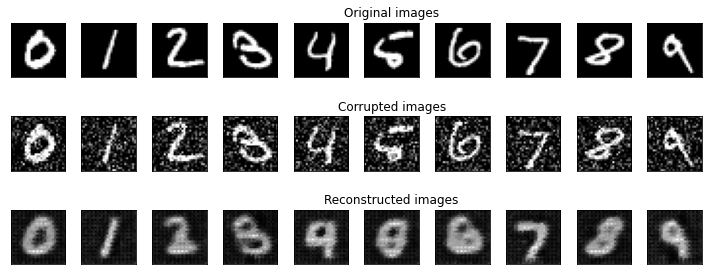

EPOCH 3/30
	 partial train loss (single batch): 0.046784
	 partial train loss (single batch): 0.047686
	 partial train loss (single batch): 0.046740
	 partial train loss (single batch): 0.046291
	 partial train loss (single batch): 0.045052
	 partial train loss (single batch): 0.045339
	 partial train loss (single batch): 0.047103
	 partial train loss (single batch): 0.046319
	 partial train loss (single batch): 0.045798
	 partial train loss (single batch): 0.046360
	 partial train loss (single batch): 0.046887
	 partial train loss (single batch): 0.047177
	 partial train loss (single batch): 0.043227
	 partial train loss (single batch): 0.045964
	 partial train loss (single batch): 0.047278
	 partial train loss (single batch): 0.044790
	 partial train loss (single batch): 0.046615
	 partial train loss (single batch): 0.046395
	 partial train loss (single batch): 0.046113
	 partial train loss (single batch): 0.046125
	 partial train loss (single batch): 0.044747
	 partial train loss (s

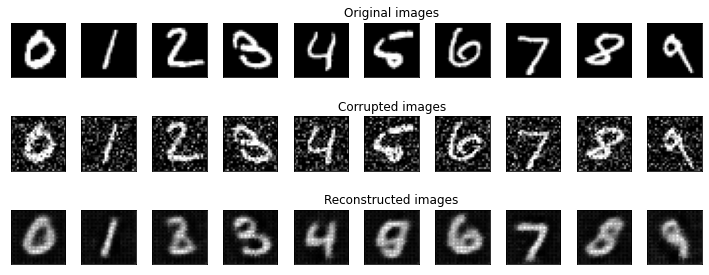

EPOCH 4/30
	 partial train loss (single batch): 0.037839
	 partial train loss (single batch): 0.039375
	 partial train loss (single batch): 0.038168
	 partial train loss (single batch): 0.037227
	 partial train loss (single batch): 0.036276
	 partial train loss (single batch): 0.036750
	 partial train loss (single batch): 0.038514
	 partial train loss (single batch): 0.037855
	 partial train loss (single batch): 0.037329
	 partial train loss (single batch): 0.038061
	 partial train loss (single batch): 0.038212
	 partial train loss (single batch): 0.039244
	 partial train loss (single batch): 0.034800
	 partial train loss (single batch): 0.037712
	 partial train loss (single batch): 0.038771
	 partial train loss (single batch): 0.036499
	 partial train loss (single batch): 0.038254
	 partial train loss (single batch): 0.037768
	 partial train loss (single batch): 0.038141
	 partial train loss (single batch): 0.038271
	 partial train loss (single batch): 0.036295
	 partial train loss (s

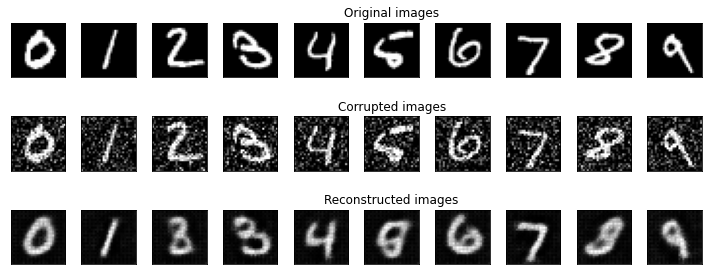

EPOCH 5/30
	 partial train loss (single batch): 0.034026
	 partial train loss (single batch): 0.035797
	 partial train loss (single batch): 0.034547
	 partial train loss (single batch): 0.033228
	 partial train loss (single batch): 0.032619
	 partial train loss (single batch): 0.033232
	 partial train loss (single batch): 0.034412
	 partial train loss (single batch): 0.034219
	 partial train loss (single batch): 0.033691
	 partial train loss (single batch): 0.034653
	 partial train loss (single batch): 0.034764
	 partial train loss (single batch): 0.035600
	 partial train loss (single batch): 0.031158
	 partial train loss (single batch): 0.034399
	 partial train loss (single batch): 0.035565
	 partial train loss (single batch): 0.032868
	 partial train loss (single batch): 0.034879
	 partial train loss (single batch): 0.034342
	 partial train loss (single batch): 0.034894
	 partial train loss (single batch): 0.034936
	 partial train loss (single batch): 0.033080
	 partial train loss (s

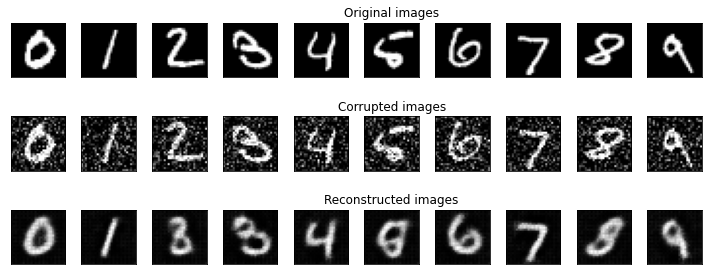

EPOCH 6/30
	 partial train loss (single batch): 0.031766
	 partial train loss (single batch): 0.034188
	 partial train loss (single batch): 0.032833
	 partial train loss (single batch): 0.031521
	 partial train loss (single batch): 0.030994
	 partial train loss (single batch): 0.031539
	 partial train loss (single batch): 0.032777
	 partial train loss (single batch): 0.032353
	 partial train loss (single batch): 0.032021
	 partial train loss (single batch): 0.033008
	 partial train loss (single batch): 0.033015
	 partial train loss (single batch): 0.034049
	 partial train loss (single batch): 0.029714
	 partial train loss (single batch): 0.032936
	 partial train loss (single batch): 0.034123
	 partial train loss (single batch): 0.031228
	 partial train loss (single batch): 0.032936
	 partial train loss (single batch): 0.032519
	 partial train loss (single batch): 0.033260
	 partial train loss (single batch): 0.033519
	 partial train loss (single batch): 0.031218
	 partial train loss (s

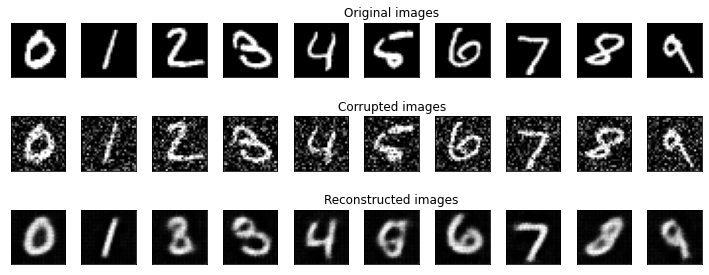

EPOCH 7/30
	 partial train loss (single batch): 0.030888
	 partial train loss (single batch): 0.032887
	 partial train loss (single batch): 0.031792
	 partial train loss (single batch): 0.030399
	 partial train loss (single batch): 0.030237
	 partial train loss (single batch): 0.030833
	 partial train loss (single batch): 0.031677
	 partial train loss (single batch): 0.031325
	 partial train loss (single batch): 0.030826
	 partial train loss (single batch): 0.032140
	 partial train loss (single batch): 0.032172
	 partial train loss (single batch): 0.033041
	 partial train loss (single batch): 0.028537
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch): 0.033032
	 partial train loss (single batch): 0.030045
	 partial train loss (single batch): 0.032087
	 partial train loss (single batch): 0.031326
	 partial train loss (single batch): 0.031909
	 partial train loss (single batch): 0.032376
	 partial train loss (single batch): 0.029860
	 partial train loss (s

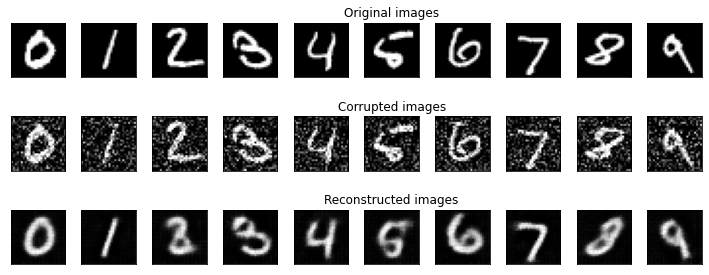

EPOCH 8/30
	 partial train loss (single batch): 0.030374
	 partial train loss (single batch): 0.032294
	 partial train loss (single batch): 0.031069
	 partial train loss (single batch): 0.029927
	 partial train loss (single batch): 0.029283
	 partial train loss (single batch): 0.030234
	 partial train loss (single batch): 0.030729
	 partial train loss (single batch): 0.030697
	 partial train loss (single batch): 0.030120
	 partial train loss (single batch): 0.031251
	 partial train loss (single batch): 0.031340
	 partial train loss (single batch): 0.032234
	 partial train loss (single batch): 0.027908
	 partial train loss (single batch): 0.030880
	 partial train loss (single batch): 0.032037
	 partial train loss (single batch): 0.029153
	 partial train loss (single batch): 0.031458
	 partial train loss (single batch): 0.030889
	 partial train loss (single batch): 0.031457
	 partial train loss (single batch): 0.031577
	 partial train loss (single batch): 0.029431
	 partial train loss (s

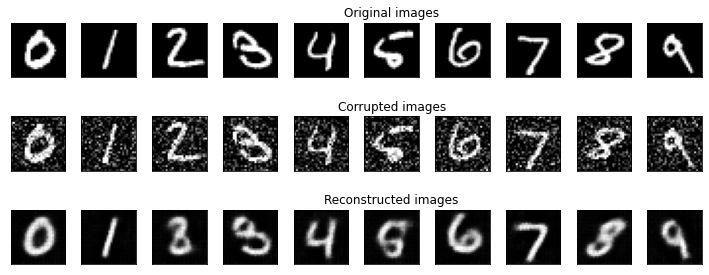

EPOCH 9/30
	 partial train loss (single batch): 0.029805
	 partial train loss (single batch): 0.031922
	 partial train loss (single batch): 0.030445
	 partial train loss (single batch): 0.029667
	 partial train loss (single batch): 0.028973
	 partial train loss (single batch): 0.029448
	 partial train loss (single batch): 0.030234
	 partial train loss (single batch): 0.029936
	 partial train loss (single batch): 0.029808
	 partial train loss (single batch): 0.030813
	 partial train loss (single batch): 0.030901
	 partial train loss (single batch): 0.031850
	 partial train loss (single batch): 0.027206
	 partial train loss (single batch): 0.030240
	 partial train loss (single batch): 0.031902
	 partial train loss (single batch): 0.028801
	 partial train loss (single batch): 0.031009
	 partial train loss (single batch): 0.030328
	 partial train loss (single batch): 0.030719
	 partial train loss (single batch): 0.030961
	 partial train loss (single batch): 0.029074
	 partial train loss (s

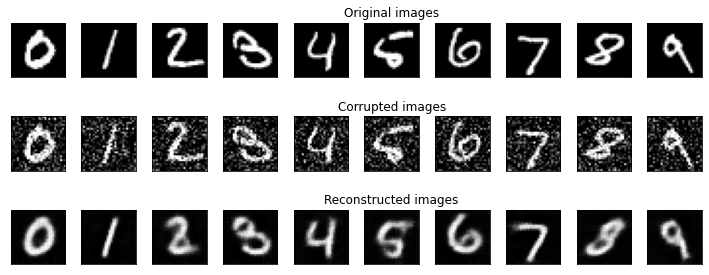

EPOCH 10/30
	 partial train loss (single batch): 0.029569
	 partial train loss (single batch): 0.031730
	 partial train loss (single batch): 0.029948
	 partial train loss (single batch): 0.029471
	 partial train loss (single batch): 0.028651
	 partial train loss (single batch): 0.029378
	 partial train loss (single batch): 0.030003
	 partial train loss (single batch): 0.029652
	 partial train loss (single batch): 0.029294
	 partial train loss (single batch): 0.030542
	 partial train loss (single batch): 0.030573
	 partial train loss (single batch): 0.031414
	 partial train loss (single batch): 0.026844
	 partial train loss (single batch): 0.029647
	 partial train loss (single batch): 0.031325
	 partial train loss (single batch): 0.028318
	 partial train loss (single batch): 0.030655
	 partial train loss (single batch): 0.029919
	 partial train loss (single batch): 0.030377
	 partial train loss (single batch): 0.030798
	 partial train loss (single batch): 0.028602
	 partial train loss (

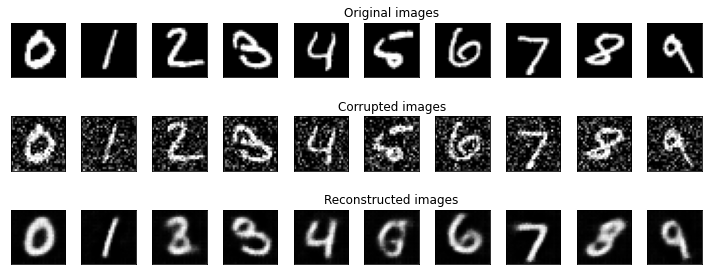

EPOCH 11/30
	 partial train loss (single batch): 0.029157
	 partial train loss (single batch): 0.031255
	 partial train loss (single batch): 0.029497
	 partial train loss (single batch): 0.028704
	 partial train loss (single batch): 0.028367
	 partial train loss (single batch): 0.028742
	 partial train loss (single batch): 0.029617
	 partial train loss (single batch): 0.029357
	 partial train loss (single batch): 0.028789
	 partial train loss (single batch): 0.030151
	 partial train loss (single batch): 0.030371
	 partial train loss (single batch): 0.031099
	 partial train loss (single batch): 0.026547
	 partial train loss (single batch): 0.029297
	 partial train loss (single batch): 0.031188
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.030338
	 partial train loss (single batch): 0.029896
	 partial train loss (single batch): 0.030052
	 partial train loss (single batch): 0.030267
	 partial train loss (single batch): 0.028588
	 partial train loss (

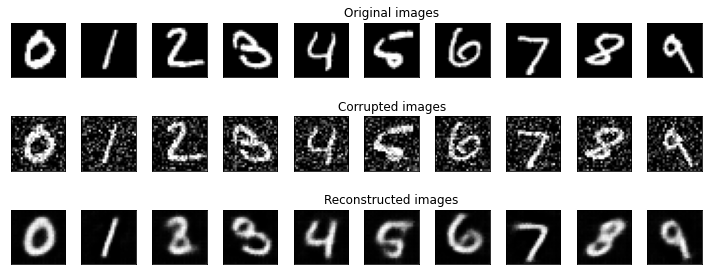

EPOCH 12/30
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch): 0.031346
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.028881
	 partial train loss (single batch): 0.028132
	 partial train loss (single batch): 0.028411
	 partial train loss (single batch): 0.029435
	 partial train loss (single batch): 0.029269
	 partial train loss (single batch): 0.028553
	 partial train loss (single batch): 0.029733
	 partial train loss (single batch): 0.030053
	 partial train loss (single batch): 0.030768
	 partial train loss (single batch): 0.026139
	 partial train loss (single batch): 0.029104
	 partial train loss (single batch): 0.030877
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.030090
	 partial train loss (single batch): 0.029491
	 partial train loss (single batch): 0.029817
	 partial train loss (single batch): 0.029897
	 partial train loss (single batch): 0.028451
	 partial train loss (

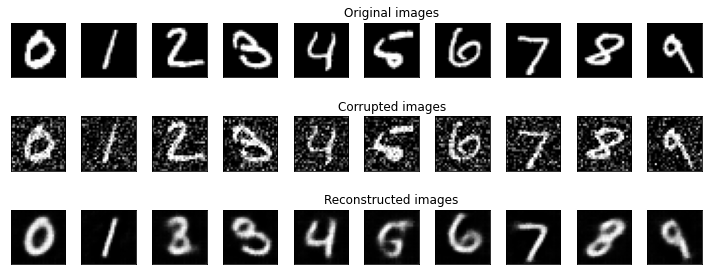

EPOCH 13/30
	 partial train loss (single batch): 0.028669
	 partial train loss (single batch): 0.030976
	 partial train loss (single batch): 0.028902
	 partial train loss (single batch): 0.028525
	 partial train loss (single batch): 0.028125
	 partial train loss (single batch): 0.028251
	 partial train loss (single batch): 0.029079
	 partial train loss (single batch): 0.028952
	 partial train loss (single batch): 0.028095
	 partial train loss (single batch): 0.029718
	 partial train loss (single batch): 0.029747
	 partial train loss (single batch): 0.030528
	 partial train loss (single batch): 0.025974
	 partial train loss (single batch): 0.029010
	 partial train loss (single batch): 0.030949
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.029828
	 partial train loss (single batch): 0.029132
	 partial train loss (single batch): 0.029420
	 partial train loss (single batch): 0.029859
	 partial train loss (single batch): 0.028135
	 partial train loss (

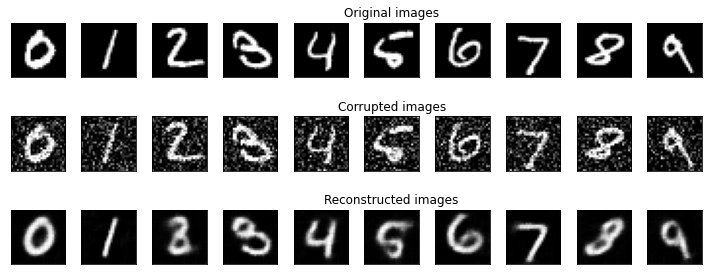

EPOCH 14/30
	 partial train loss (single batch): 0.028613
	 partial train loss (single batch): 0.030649
	 partial train loss (single batch): 0.028671
	 partial train loss (single batch): 0.028032
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.027890
	 partial train loss (single batch): 0.028993
	 partial train loss (single batch): 0.028478
	 partial train loss (single batch): 0.027734
	 partial train loss (single batch): 0.029563
	 partial train loss (single batch): 0.029364
	 partial train loss (single batch): 0.030241
	 partial train loss (single batch): 0.025756
	 partial train loss (single batch): 0.028649
	 partial train loss (single batch): 0.030507
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.029309
	 partial train loss (single batch): 0.029021
	 partial train loss (single batch): 0.029232
	 partial train loss (single batch): 0.029388
	 partial train loss (single batch): 0.027875
	 partial train loss (

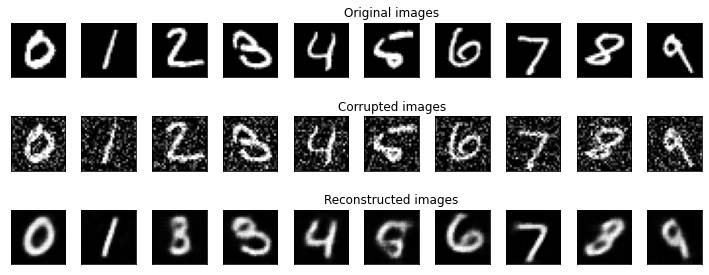

EPOCH 15/30
	 partial train loss (single batch): 0.028359
	 partial train loss (single batch): 0.030559
	 partial train loss (single batch): 0.028301
	 partial train loss (single batch): 0.027984
	 partial train loss (single batch): 0.027551
	 partial train loss (single batch): 0.027668
	 partial train loss (single batch): 0.028580
	 partial train loss (single batch): 0.028454
	 partial train loss (single batch): 0.027484
	 partial train loss (single batch): 0.029258
	 partial train loss (single batch): 0.029243
	 partial train loss (single batch): 0.030198
	 partial train loss (single batch): 0.025629
	 partial train loss (single batch): 0.028360
	 partial train loss (single batch): 0.030421
	 partial train loss (single batch): 0.026459
	 partial train loss (single batch): 0.029294
	 partial train loss (single batch): 0.028840
	 partial train loss (single batch): 0.029006
	 partial train loss (single batch): 0.029225
	 partial train loss (single batch): 0.027879
	 partial train loss (

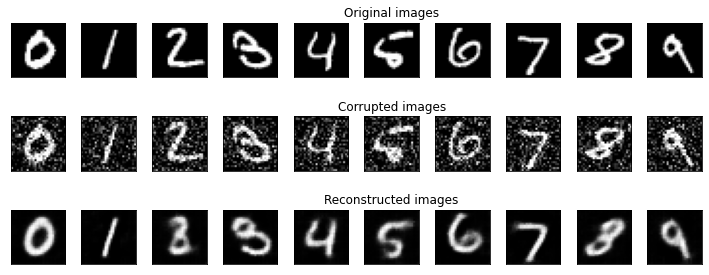

EPOCH 16/30
	 partial train loss (single batch): 0.028269
	 partial train loss (single batch): 0.030341
	 partial train loss (single batch): 0.028113
	 partial train loss (single batch): 0.028158
	 partial train loss (single batch): 0.027348
	 partial train loss (single batch): 0.027598
	 partial train loss (single batch): 0.028262
	 partial train loss (single batch): 0.028521
	 partial train loss (single batch): 0.027586
	 partial train loss (single batch): 0.029073
	 partial train loss (single batch): 0.029249
	 partial train loss (single batch): 0.029893
	 partial train loss (single batch): 0.025309
	 partial train loss (single batch): 0.028319
	 partial train loss (single batch): 0.030363
	 partial train loss (single batch): 0.026488
	 partial train loss (single batch): 0.029619
	 partial train loss (single batch): 0.028834
	 partial train loss (single batch): 0.029029
	 partial train loss (single batch): 0.029315
	 partial train loss (single batch): 0.027836
	 partial train loss (

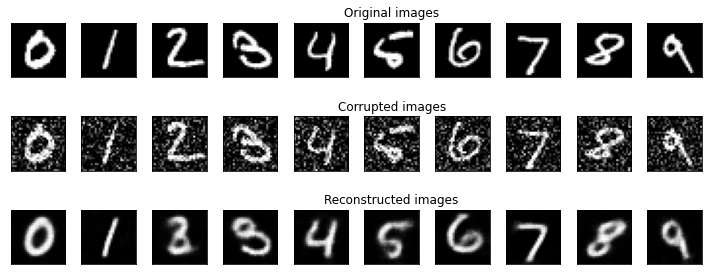

EPOCH 17/30
	 partial train loss (single batch): 0.028082
	 partial train loss (single batch): 0.030196
	 partial train loss (single batch): 0.027984
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.027113
	 partial train loss (single batch): 0.027676
	 partial train loss (single batch): 0.028457
	 partial train loss (single batch): 0.028283
	 partial train loss (single batch): 0.027344
	 partial train loss (single batch): 0.028990
	 partial train loss (single batch): 0.028980
	 partial train loss (single batch): 0.029598
	 partial train loss (single batch): 0.025292
	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.030309
	 partial train loss (single batch): 0.026188
	 partial train loss (single batch): 0.029090
	 partial train loss (single batch): 0.028586
	 partial train loss (single batch): 0.028495
	 partial train loss (single batch): 0.028954
	 partial train loss (single batch): 0.027823
	 partial train loss (

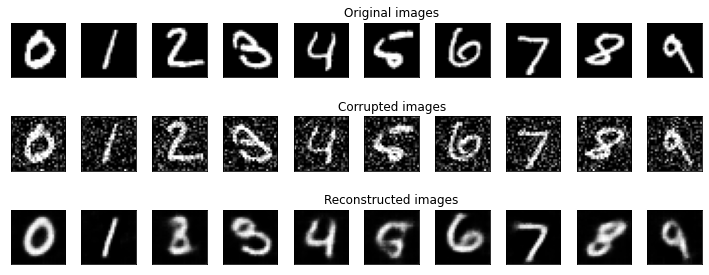

EPOCH 18/30
	 partial train loss (single batch): 0.027731
	 partial train loss (single batch): 0.029926
	 partial train loss (single batch): 0.027995
	 partial train loss (single batch): 0.027795
	 partial train loss (single batch): 0.027169
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.028127
	 partial train loss (single batch): 0.028160
	 partial train loss (single batch): 0.027327
	 partial train loss (single batch): 0.028854
	 partial train loss (single batch): 0.028914
	 partial train loss (single batch): 0.029494
	 partial train loss (single batch): 0.024970
	 partial train loss (single batch): 0.028095
	 partial train loss (single batch): 0.030153
	 partial train loss (single batch): 0.026131
	 partial train loss (single batch): 0.028989
	 partial train loss (single batch): 0.028389
	 partial train loss (single batch): 0.028420
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch): 0.027395
	 partial train loss (

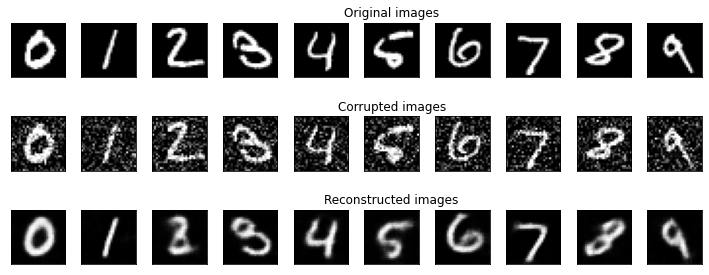

EPOCH 19/30
	 partial train loss (single batch): 0.027794
	 partial train loss (single batch): 0.030049
	 partial train loss (single batch): 0.027787
	 partial train loss (single batch): 0.027884
	 partial train loss (single batch): 0.027082
	 partial train loss (single batch): 0.027305
	 partial train loss (single batch): 0.028029
	 partial train loss (single batch): 0.027858
	 partial train loss (single batch): 0.026986
	 partial train loss (single batch): 0.028618
	 partial train loss (single batch): 0.028900
	 partial train loss (single batch): 0.029591
	 partial train loss (single batch): 0.024817
	 partial train loss (single batch): 0.027935
	 partial train loss (single batch): 0.030074
	 partial train loss (single batch): 0.025986
	 partial train loss (single batch): 0.028778
	 partial train loss (single batch): 0.028139
	 partial train loss (single batch): 0.028374
	 partial train loss (single batch): 0.028386
	 partial train loss (single batch): 0.027407
	 partial train loss (

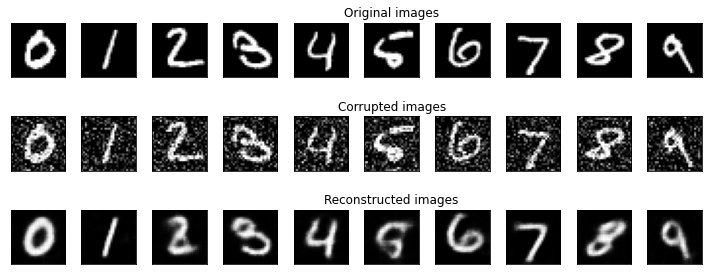

EPOCH 20/30
	 partial train loss (single batch): 0.027763
	 partial train loss (single batch): 0.029988
	 partial train loss (single batch): 0.027409
	 partial train loss (single batch): 0.027573
	 partial train loss (single batch): 0.026902
	 partial train loss (single batch): 0.027378
	 partial train loss (single batch): 0.028107
	 partial train loss (single batch): 0.027745
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.028485
	 partial train loss (single batch): 0.028973
	 partial train loss (single batch): 0.029423
	 partial train loss (single batch): 0.024805
	 partial train loss (single batch): 0.027970
	 partial train loss (single batch): 0.030130
	 partial train loss (single batch): 0.026220
	 partial train loss (single batch): 0.029040
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.028300
	 partial train loss (single batch): 0.028470
	 partial train loss (single batch): 0.027395
	 partial train loss (

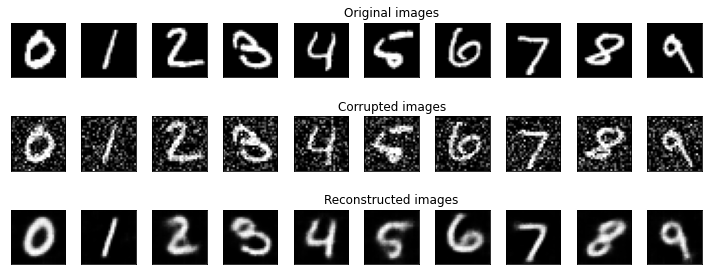

EPOCH 21/30
	 partial train loss (single batch): 0.027442
	 partial train loss (single batch): 0.029820
	 partial train loss (single batch): 0.027117
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.026552
	 partial train loss (single batch): 0.027047
	 partial train loss (single batch): 0.027747
	 partial train loss (single batch): 0.027559
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.028490
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.029176
	 partial train loss (single batch): 0.024712
	 partial train loss (single batch): 0.027556
	 partial train loss (single batch): 0.029845
	 partial train loss (single batch): 0.026246
	 partial train loss (single batch): 0.028667
	 partial train loss (single batch): 0.027842
	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.028403
	 partial train loss (single batch): 0.027223
	 partial train loss (

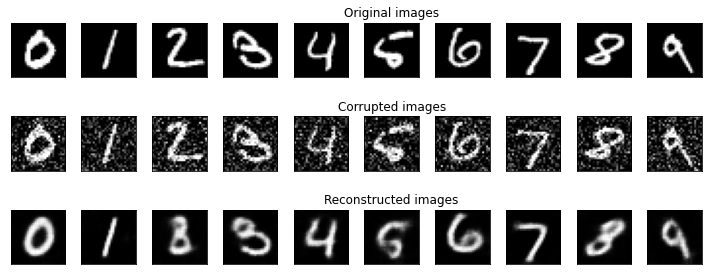

EPOCH 22/30
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.029763
	 partial train loss (single batch): 0.027288
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.026698
	 partial train loss (single batch): 0.027081
	 partial train loss (single batch): 0.027782
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.026749
	 partial train loss (single batch): 0.028249
	 partial train loss (single batch): 0.028317
	 partial train loss (single batch): 0.029372
	 partial train loss (single batch): 0.024701
	 partial train loss (single batch): 0.027445
	 partial train loss (single batch): 0.029706
	 partial train loss (single batch): 0.025788
	 partial train loss (single batch): 0.028341
	 partial train loss (single batch): 0.027915
	 partial train loss (single batch): 0.027940
	 partial train loss (single batch): 0.028036
	 partial train loss (single batch): 0.027224
	 partial train loss (

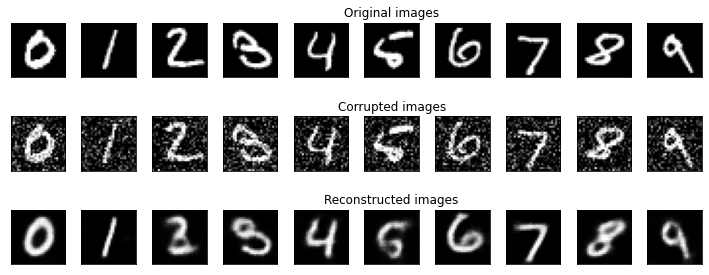

EPOCH 23/30
	 partial train loss (single batch): 0.027379
	 partial train loss (single batch): 0.029578
	 partial train loss (single batch): 0.027157
	 partial train loss (single batch): 0.027483
	 partial train loss (single batch): 0.026335
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.027860
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.026588
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.029030
	 partial train loss (single batch): 0.024558
	 partial train loss (single batch): 0.027463
	 partial train loss (single batch): 0.029399
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.028284
	 partial train loss (single batch): 0.027743
	 partial train loss (single batch): 0.028090
	 partial train loss (single batch): 0.028002
	 partial train loss (single batch): 0.027006
	 partial train loss (

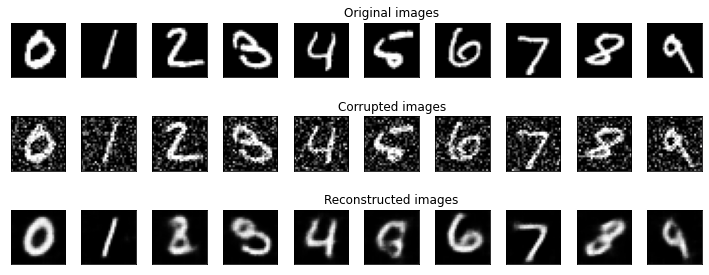

EPOCH 24/30
	 partial train loss (single batch): 0.027065
	 partial train loss (single batch): 0.029421
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.027465
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch): 0.026822
	 partial train loss (single batch): 0.027614
	 partial train loss (single batch): 0.027263
	 partial train loss (single batch): 0.026528
	 partial train loss (single batch): 0.028395
	 partial train loss (single batch): 0.028438
	 partial train loss (single batch): 0.029028
	 partial train loss (single batch): 0.024498
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.029255
	 partial train loss (single batch): 0.025690
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.027584
	 partial train loss (single batch): 0.027727
	 partial train loss (single batch): 0.028124
	 partial train loss (single batch): 0.026917
	 partial train loss (

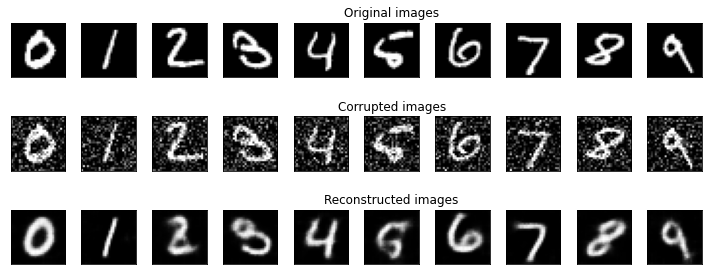

EPOCH 25/30
	 partial train loss (single batch): 0.027122
	 partial train loss (single batch): 0.029350
	 partial train loss (single batch): 0.027130
	 partial train loss (single batch): 0.027496
	 partial train loss (single batch): 0.026440
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.027729
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch): 0.028221
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.029046
	 partial train loss (single batch): 0.024664
	 partial train loss (single batch): 0.027367
	 partial train loss (single batch): 0.029272
	 partial train loss (single batch): 0.025332
	 partial train loss (single batch): 0.027979
	 partial train loss (single batch): 0.027744
	 partial train loss (single batch): 0.027920
	 partial train loss (single batch): 0.027945
	 partial train loss (single batch): 0.027174
	 partial train loss (

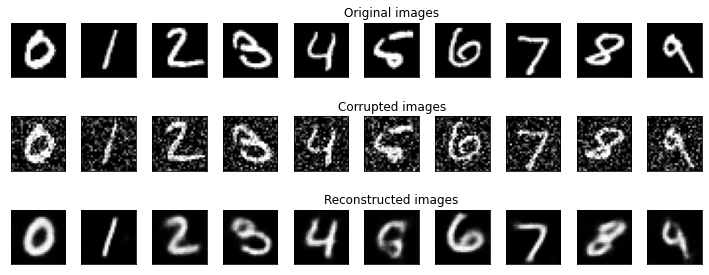

EPOCH 26/30
	 partial train loss (single batch): 0.026922
	 partial train loss (single batch): 0.028999
	 partial train loss (single batch): 0.026997
	 partial train loss (single batch): 0.027320
	 partial train loss (single batch): 0.026342
	 partial train loss (single batch): 0.026874
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.026997
	 partial train loss (single batch): 0.026170
	 partial train loss (single batch): 0.028045
	 partial train loss (single batch): 0.028479
	 partial train loss (single batch): 0.028922
	 partial train loss (single batch): 0.024497
	 partial train loss (single batch): 0.027286
	 partial train loss (single batch): 0.029584
	 partial train loss (single batch): 0.025540
	 partial train loss (single batch): 0.027942
	 partial train loss (single batch): 0.027364
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.028128
	 partial train loss (single batch): 0.027028
	 partial train loss (

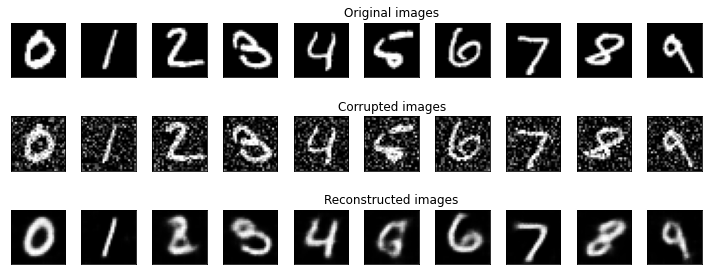

EPOCH 27/30
	 partial train loss (single batch): 0.026964
	 partial train loss (single batch): 0.029274
	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.027206
	 partial train loss (single batch): 0.026150
	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.027760
	 partial train loss (single batch): 0.026835
	 partial train loss (single batch): 0.026419
	 partial train loss (single batch): 0.027798
	 partial train loss (single batch): 0.028025
	 partial train loss (single batch): 0.028824
	 partial train loss (single batch): 0.024274
	 partial train loss (single batch): 0.027028
	 partial train loss (single batch): 0.029058
	 partial train loss (single batch): 0.025392
	 partial train loss (single batch): 0.027997
	 partial train loss (single batch): 0.027128
	 partial train loss (single batch): 0.027424
	 partial train loss (single batch): 0.027711
	 partial train loss (single batch): 0.026887
	 partial train loss (

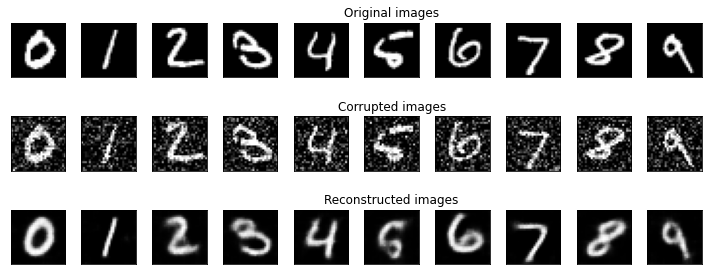

EPOCH 28/30
	 partial train loss (single batch): 0.026622
	 partial train loss (single batch): 0.029260
	 partial train loss (single batch): 0.026982
	 partial train loss (single batch): 0.027134
	 partial train loss (single batch): 0.026018
	 partial train loss (single batch): 0.026691
	 partial train loss (single batch): 0.027246
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.026185
	 partial train loss (single batch): 0.028001
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.028927
	 partial train loss (single batch): 0.024154
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.029224
	 partial train loss (single batch): 0.025335
	 partial train loss (single batch): 0.027870
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.027596
	 partial train loss (single batch): 0.027486
	 partial train loss (single batch): 0.026701
	 partial train loss (

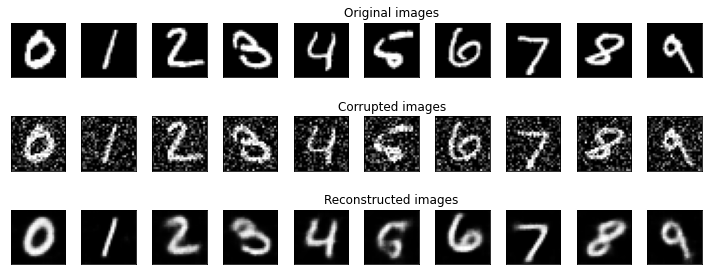

EPOCH 29/30
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.028977
	 partial train loss (single batch): 0.026705
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.026204
	 partial train loss (single batch): 0.026652
	 partial train loss (single batch): 0.027292
	 partial train loss (single batch): 0.026882
	 partial train loss (single batch): 0.026056
	 partial train loss (single batch): 0.028027
	 partial train loss (single batch): 0.028209
	 partial train loss (single batch): 0.028813
	 partial train loss (single batch): 0.024364
	 partial train loss (single batch): 0.026954
	 partial train loss (single batch): 0.029040
	 partial train loss (single batch): 0.025510
	 partial train loss (single batch): 0.028011
	 partial train loss (single batch): 0.027294
	 partial train loss (single batch): 0.027389
	 partial train loss (single batch): 0.027618
	 partial train loss (single batch): 0.026767
	 partial train loss (

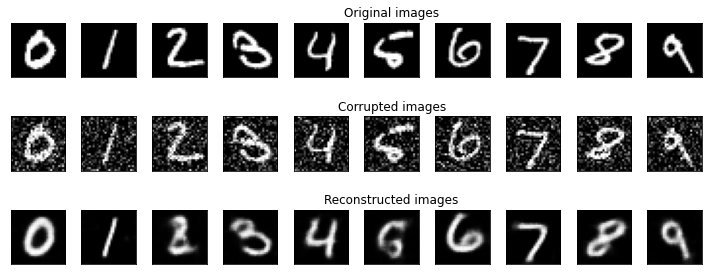

EPOCH 30/30
	 partial train loss (single batch): 0.026494
	 partial train loss (single batch): 0.029012
	 partial train loss (single batch): 0.026658
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch): 0.026056
	 partial train loss (single batch): 0.026608
	 partial train loss (single batch): 0.027434
	 partial train loss (single batch): 0.026813
	 partial train loss (single batch): 0.026076
	 partial train loss (single batch): 0.027658
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch): 0.028525
	 partial train loss (single batch): 0.024060
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.029226
	 partial train loss (single batch): 0.024848
	 partial train loss (single batch): 0.027945
	 partial train loss (single batch): 0.027250
	 partial train loss (single batch): 0.027231
	 partial train loss (single batch): 0.027488
	 partial train loss (single batch): 0.026841
	 partial train loss (

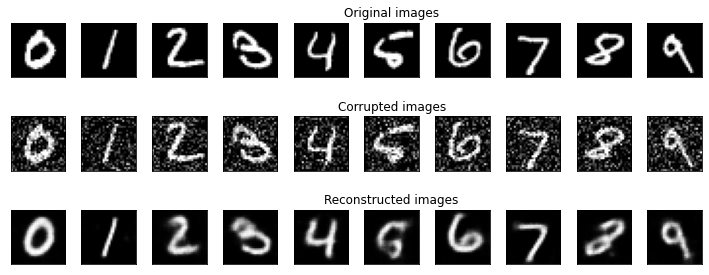

In [ ]:
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

tensor([-0.1265,  0.0384,  0.0788,  0.0023])
tensor([0.6466, 0.5645, 0.5733, 0.5971])


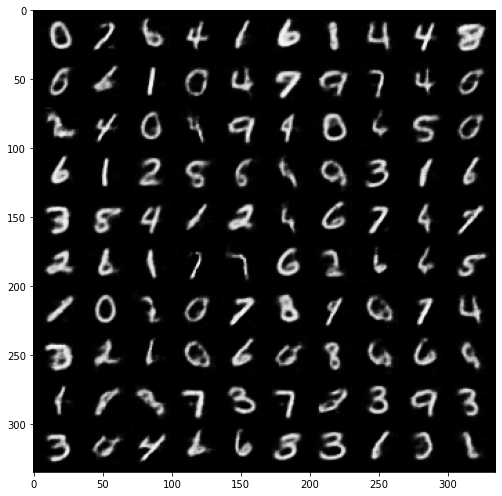

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [ ]:

encoded_samples = []
for sample in test_loader:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img[0])
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples





      #img = test_dataset[t_idx[i]][0].unsqueeze(0)

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0         -0.056410         0.597580        -0.083030        -0.204986   
1          0.069017         0.121364        -0.793635        -1.074218   
2         -1.275288         0.158727         0.845384         0.464552   
3          0.034025        -0.055985         0.328903        -0.472462   
4         -1.430694         0.397423        -1.417074        -0.178263   
5         -0.618981         0.413759        -0.083691         0.279320   
6         -0.285111        -0.098490        -0.363370        -0.028091   
7          0.003581        -0.047090        -0.088412        -0.792626   
8          0.090202        -0.483287         0.029055        -0.127878   
9          0.895473         0.232094         0.742194         0.528575   
10        -0.018417         0.610397        -0.582013        -1.305904   
11         0.061041        -0.138829        -0.362796         0.112252   
12        -1.076048        -1.190431         1.280253        -0.629961   
13         0.740124        -0.139286         0.326828        -0.678015   
14        -0.463757        -0.928234         0.960018        -0.118328   
15         1.151359        -0.481664         0.325931         0.558112   
16         0.316474         0.128628         0.609972         0.292959   
17         0.305491         0.361399        -0.213040         0.354478   
18        -0.012580        -0.398525         0.056979        -0.192420   
19         0.405945        -0.139410        -0.055526        -0.447091   
20        -0.056335        -0.179611         0.289632        -0.249002   
21        -0.028683         1.150999         0.138947         0.291572   
22        -0.461929        -0.609116         0.676192        -0.175302   
23         1.136528         0.015274        -0.355647        -0.728870   
24         0.322400        -0.443893         0.006616        -0.567337   
25        -0.773053        -0.810859         0.791154        -0.091565   
26         1.244143         0.368593        -0.796734        -2.184035   
27        -0.627355        -0.819053         0.647022        -0.252016   
28         0.096633        -0.239599         0.664081        -0.534359   
29         1.286171        -0.050539         1.443459         0.840441   
30        -0.732405        -0.842661         0.490179        -0.029983   
31        -0.218770         0.682651        -0.277553        -0.436752   
32         0.075884         0.435794         0.191228         0.083234   
33         0.285852         0.448321        -0.154453         0.312666   
34        -0.580183        -0.786591         0.582264        -0.345921   
35         1.136405        -1.200274         1.550537         0.933197   
36        -0.879829         0.309200        -1.187780        -0.804634   
37        -0.011986        -0.022346        -0.071334        -0.517149   
38         0.505803         0.395724         0.355542        -0.441127   
39        -1.442935         0.716713        -0.652951        -0.708088   

    Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0         -0.717120         0.659275        -0.284122         0.207962   
1         -1.636342         0.099423         0.776056         0.148331   
2          0.361568        -0.233913         0.484113        -0.085901   
3         -0.227645        -0.065902        -0.395373        -0.295428   
4          0.641677         0.890627         0.155805         0.721375   
5          0.343788        -0.368516        -0.169610         0.061784   
6          0.431433         0.224877        -0.441478         0.718741   
7          0.911292        -1.071443         1.093580         1.261814   
8          0.142736         0.974005        -0.237555         0.341630   
9          0.349216         0.383397        -0.018425         0.537768   
10        -0.545997        -0.989273         0.524924        -0.041427   
11         0.896321         0.846177         0.058937        -0.723824   
12     

In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
try:
  tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
  fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
except NameError:
  print("Variable x is not defined")
fig.show()